In [9]:
import pandas as pd
import numpy as np
from functools import partial
from scipy.optimize import minimize, Bounds
from scipy.stats import binom
from sklearn.utils.fixes import logsumexp
from sklearn.model_selection import train_test_split
import seaborn as sns

# Political Blog Classification

You have already seen this data in class. Your job is simply to build a classifier that learns to classify blogs as "conservative" or "liberal" based on their word usage.

In [2]:
word_count = pd.read_csv('poliblog_wordcount.csv').drop('Unnamed: 0', 1)
ratings = pd.read_csv('poliblog_ratings.csv', usecols=[1])['poliblog.ratings']

X_train, X_test, y_train, y_test = train_test_split(word_count, ratings)

In [601]:
class MClassifier():
    def __init__(self, class_priors = [.5,.5], alpha = 0.00001):
        self.alpha = alpha 
        self.priors = np.log(class_priors)

    def ml(self, df):
        arr = df.values        
        a = arr.sum(0) / arr.sum()
        # smoothing for non-infinite values
        a[a == 0] = self.alpha
        return np.log(a)
    
    def fit(self, X, y):
        self.classes = y_train.unique()
        self.probs = [self.ml(X[y == c]) for c in self.classes]

    def predict_proba(self, X):
        probs = np.array([[x.dot(p) + pri 
                           for p,pri in zip(self.probs, self.priors)] 
                          for _,x in X.iterrows()])

        # Normalize to give proper distribution!
        probs = (probs - logsumexp(probs, axis=1)[:,np.newaxis])
        return np.exp(probs)    

    def predict(self, X):
        p = [np.argmax(p) for p in self.predict_proba(X)]
        return np.array([self.classes[i] for i in p])    

In [ ]:
# see how your algorithm does

c = MClassifier(class_priors = [.5, 5])
c.fit(X_train, y_train)

(c.predict(X_test) != y_test).sum()

# EM algorithm for Binomial data

You are a run-of-the-mill magician, working the streets to make ends meet. One of your staple tricks relies on having special fake coins, which are biased. 

Ufortunately, something has gone wrong, and you have forgotten which coins are biased in which way (more heads? more tails? You can't remember!). You know that there are 2 types of coins, but you have hundreds. 

You decide to flip each coin 30 times, and record the number of times it comes up heads. Based on this data, you need to determine, which coin is of which type, and estimate the bias of each type, so that you can get back to the streets and make that bread.

In [660]:
def sim(n, p, N):
    p = p + np.random.normal(0,.02,1)
    return np.random.binomial(n, p, N)

n = 30
k = np.concatenate([sim(n, .35, 50), sim(n, .6, 200)])
pd.DataFrame(k, columns = ['heads']).to_csv('coins.csv', index=False)

In [676]:
def e_step(k, n, prev_betas, p_z):
    # p(z) is prior on labels, which is updated each time

    # likelihood = p(w | z, B)
    likelihood = np.array([binom.pmf(k, n, b) for b in prev_betas]).T

    # p(w,z,B) = p(w | z, B)p(z)p(B) >> here we are ignoring p(B):
    # p(w,z) = p(w | z)p(z)
    # implicitly assuming it to be uniform: p(w,z) = \int_B p(w,z | B)p(B)
    joint = (likelihood * p_z)

    # p(z | w) = p(w,z) / normalizing_constant
    normalizing_constant = joint.sum(axis=1)[:, np.newaxis]
    return joint / normalizing_constant


def m_step(k, n, responsiblity):
    # Our "prior" on the distribution of class labels
    # This calculates from our posterior:
    # p(z) = \sum_w p(z | w)p(w)
    p_z = responsiblity.sum(axis=0) / k.shape[0]

    # turn our data into a percentage of heads, 
    # rather than binomial output (counts of heads)
    w = k/n

    # argmax_B \sum_z p(w | B,z)p(z | w)
    # But of course, argmax B for a binomial distribution
    # is simply the mean: 
    # E[w | z] = \sum_w  w * p(w | z)
    # where:
    # p(w|z) = p(z|w)p(w) / p(z)
    p_w = 1 / k.shape[0]
    betas = np.dot(responsiblity.T, w) * p_w / p_z  
    return betas, p_z

def em(k, n, betas, p_z):
    dif = 1000
    while dif > 1e-7:
        responsibility = e_step(k, n, betas, p_z)
        new_betas, p_z = m_step(k, n, responsibility)
        dif = np.linalg.norm(new_betas - betas)
        betas = new_betas

    return betas, p_z

In [677]:
k = pd.read_csv('coins.csv').heads.values
n = 30

init_betas = [0.01, .99]
init_p_z = [0.5, 0.5]

betas, p_z = em(k, n, init_betas, init_p_z)

betas

array([ 0.33613221,  0.62556944])

# Simple Binomial updating

Practise visualizing the conjugate posterior updates of a Beta-Binomial model!

https://en.wikipedia.org/wiki/Conjugate_prior

In [ ]:
coin_heads = 20
coin_tails = 15

prior_alpha = 2
prior_beta = 2

alpha = prior_alpha + coin_heads
beta = prior_alpha + coin_tails
sns.distplot(np.random.beta(alpha, beta, size = 10000))

# EM for multinomial

Using your own solution, or mine from the answers branch, revisit the multinomial (naive bayes) text classifier and attempt to perform the same problem in an unsupervised fashion: without the labels, try and recover two clusters using a mixter of multinomials model.

# Problems with Wages

In this problem , you will see (simulated) data for "wages" in an industry.
 
We believe that wages come from "high skill" and "low skill" workers, with "high skill" workers earning more. But "skill" is a latent variable that we cannot measure. The only data we have is the wages themselves. 

With this data, estimate the percentage of high skill vs. low skill workers in the industry, and say something about the difference in how they are paid.

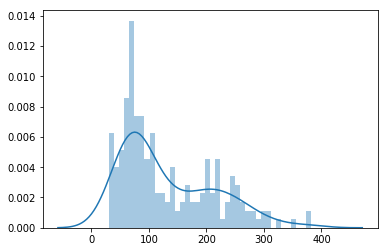

In [568]:
wages = pd.read_csv('wages.csv')
sns.distplot(wages.values, bins=40)

In [ ]:
# SIMULATE WAGE DATA

In [ ]:
params = [(8,10,125), (15,15,75)]
X = np.hstack([np.random.gamma(a,b,N) for a,b,N in params])
_ = sns.distplot(X, bins = 40)

In [566]:
pd.DataFrame(X, columns=['wage']).to_csv('wages.csv', index=False)